<a href="https://colab.research.google.com/github/Mal-web-cmd/Python_Libraries/blob/Mal-web-cmd-Chatbot/foodbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gradio as gr

In [ ]:
data=pd.read_excel('/content/Theta_bot.xlsx')

In [ ]:
data.head()

,Unnamed: 0,restaurant_id,category,name,description,price,Review,Rating,index,city,...,address,loc_name,loc_number,latitude,longitude,is_open,closed_message,delivery_fee,scan_date,TID
0,0,1,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD,nice hotel expensive parking got good deal sta...,4,0,Alexander City,...,"4097 U S Highway 280, Alexander City, AL 35010",The Saucy Hen (4097 U. S. HIGHWAY 280),0623b7ac-598d-5016-bdd2-febb44d79b12,32.923880,-85.95965,False,Opens at 11:00 AM,NaN,2022-11-09 18:03:43,1
1,1,1,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD,ok nothing special charge diamond member hilto...,2,1,Albertville,...,"7300 Hwy 431 North, Albertville, AL 35951",Burger King (7300 Hwy 431 North),62a60773-5644-4d73-b969-a4922ce70fa6,34.277260,-86.20611,True,NaN,NaN,2022-11-09 18:03:43,2
2,2,1,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD,nice rooms not 4* experience hotel monaco seat...,3,2,Alexander City,...,"4097 Us Highway 280, Alexander City, AL 35010",MrBeast Burger (4097 US Highway 280),308b1654-60f1-51d4-bfe2-ed7c849442ac,32.923880,-85.95965,False,Opens at 11:00 AM,NaN,2022-11-09 18:03:43,3
3,3,1,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD,"unique, great stay, wonderful time hotel monac...",5,3,Albertville,...,"7959 Us Hwy 431, Albertville, AL 35950",Taco Bell (7959 Us Highway 431),ef86513f-3973-4315-b938-bb6f230c5c58,34.280000,-86.21703,True,NaN,NaN,2022-11-09 18:03:43,4
4,4,1,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD,"great stay great stay, went seahawk game aweso...",5,4,Alexander City,...,"977 Jefferson St, Alexander City, AL 35010",The Station,9507eb1b-5afc-4ee1-a566-526d9e2ba2d0,32.956127,-85.94433,False,Opens at 11:00 AM,NaN,2022-11-09 18:03:43,5


In [ ]:
data = data[['restaurant_id','category','name','description','price','Review']]
data.head()

,restaurant_id,category,name,description,price,Review
0,1,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD,nice hotel expensive parking got good deal sta...
1,1,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD,ok nothing special charge diamond member hilto...
2,1,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD,nice rooms not 4* experience hotel monaco seat...
3,1,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD,"unique, great stay, wonderful time hotel monac..."
4,1,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD,"great stay great stay, went seahawk game aweso..."


In [ ]:
data['name'].value_counts()

,count
name,
Ben and Jerry's Chocolate Chip Cookie Dough,4
Ben and Jerry's Half Baked,4
Ben and Jerry's Tonight Dough,4
Ben and Jerry's Americone Dream,4
Ben and Jerry's Strawberry Cheesecake,4
...,...
Jinsei Salad,1
Baby Greens,1
Wakame,1


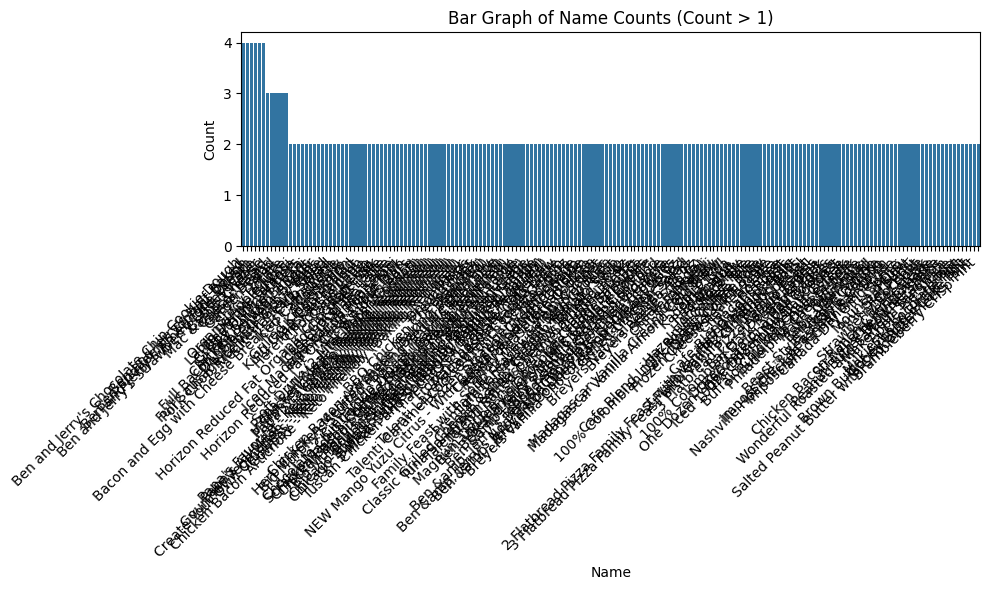

In [ ]:
#plotting to filter out the repeated items
name_counts = data['name'].value_counts()
filtered_names = name_counts[name_counts > 1]
plt.figure(figsize=(10, 6))
sns.barplot(x=filtered_names.index, y=filtered_names.values)
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Bar Graph of Name Counts (Count > 1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
#lowecase conversion and removing special characters
def standardize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
# Check for missing values
print(data.isnull().sum())

restaurant_id      0
category           0
name               0
description      144
price              0
Review             0
dtype: int64


In [ ]:
# Handling missing values (using numerical)
numerical_cols = data.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if data[col].isnull().any():
        data[col].fillna(data[col].mean(), inplace=True)

In [ ]:
# Handling missing values (using categorical)
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if data[col].isnull().any():
        data[col].fillna(data[col].mode()[0], inplace=True)

<ipython-input-95-9adc0efb2b66>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


In [ ]:
print(data.isnull().sum())

restaurant_id    0
category         0
name             0
description      0
price            0
Review           0
dtype: int64


In [ ]:
# Removing duplicate rows
data = data.drop_duplicates()

In [ ]:
data

,restaurant_id,category,name,description,price,Review
0,1,Extra Large Pizza,Extra Large Meat Lovers,Whole pie.,15.99 USD,nice hotel expensive parking got good deal sta...
1,1,Extra Large Pizza,Extra Large Supreme,Whole pie.,15.99 USD,ok nothing special charge diamond member hilto...
2,1,Extra Large Pizza,Extra Large Pepperoni,Whole pie.,14.99 USD,nice rooms not 4* experience hotel monaco seat...
3,1,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,Whole Pie,15.99 USD,"unique, great stay, wonderful time hotel monac..."
4,1,Extra Large Pizza,Extra Large 5 Cheese,Whole pie.,14.99 USD,"great stay great stay, went seahawk game aweso..."
...,...,...,...,...,...,...
995,21,Shakes - Fruity,Cap'n Crunch Shake,"200 to 250 calories, 24 to 32 grams protein, 1...",8.5 USD,average price hotel good location 1.5 blocks u...
996,21,Shakes - Fruity,PB Banana Shake,"200 to 250 calories, 24 to 32 grams protein, 1...",8.5 USD,good customer service recently wrote dissatisf...
997,21,Shakes - Fruity,Banana Bread Shake,"200 to 250 calories, 24 to 32 grams protein, 1...",8.5 USD,ignore bad press just post review reading nega...
998,21,Shakes - Fruity,Strawberry Banana Shake,"200 to 250 calories, 24 to 32 grams protein, 1...",8.5 USD,"business trip ok hotel fine evening business, ..."


#Sentiment analysis

In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
stop_words = set(stopwords.words('english'))